### 1.Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
import joblib


### 2.Load & Clean Dataset

In [2]:
df = pd.read_csv("NewsCategorizer.csv")
df.head(2)

,category,headline,links,short_description,keywords
0,WELLNESS,143 Miles in 35 Days: Lessons Learned,https://www.huffingtonpost.com/entry/running-l...,Resting is part of training. I've confirmed wh...,running-lessons
1,WELLNESS,Talking to Yourself: Crazy or Crazy Helpful?,https://www.huffingtonpost.com/entry/talking-t...,Think of talking to yourself as a tool to coac...,talking-to-yourself-crazy


In [3]:
df.shape

(50000, 5)

In [4]:
# Drop any rows with missing values
df.dropna(inplace=True)

In [5]:
# Check how many unique categories we have
category_distribution = df['category'].value_counts()
category_distribution

category
TRAVEL            4865
FOOD & DRINK      4863
ENTERTAINMENT     4855
WORLD NEWS        4851
SPORTS            4759
WELLNESS          4741
POLITICS          4712
STYLE & BEAUTY    4708
BUSINESS          4512
PARENTING         4466
Name: count, dtype: int64

In [6]:
# Preview the cleaned data
df_cleaned_preview = df[['category', 'headline']].head()
df_cleaned_preview

,category,headline
0,WELLNESS,143 Miles in 35 Days: Lessons Learned
1,WELLNESS,Talking to Yourself: Crazy or Crazy Helpful?
2,WELLNESS,Crenezumab: Trial Will Gauge Whether Alzheimer...
3,WELLNESS,"Oh, What a Difference She Made"
4,WELLNESS,Green Superfoods


In [7]:
# Text preprocessing
df['headline'] = df['headline'].str.lower()  # Lowercase all text
df['headline'] = df['headline'].str.replace(r'[^a-z\s]', '', regex=True)  # Remove punctuation/symbols
df['headline'] = df['headline'].str.replace(r'\s+', ' ', regex=True).str.strip()  # Normalize spaces

# Preview cleaned headlines
df['headline'].head(5)


0                        miles in days lessons learned
1           talking to yourself crazy or crazy helpful
2    crenezumab trial will gauge whether alzheimers...
3                        oh what a difference she made
4                                     green superfoods
Name: headline, dtype: object

### 3.Ploting the datasets

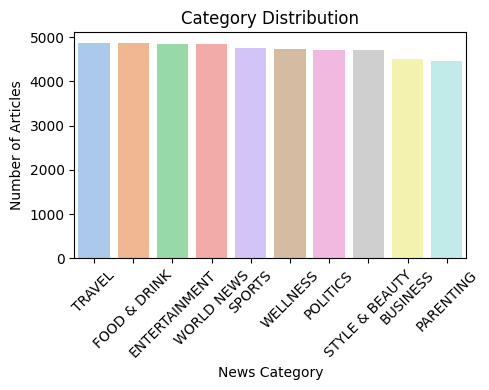

In [8]:
# Prepare value counts as a DataFrame
category_counts = df['category'].value_counts().reset_index()
category_counts.columns = ['Category', 'Count']

# Seaborn barplot
plt.figure(figsize=(5, 4))
sns.barplot(data=category_counts, x='Category', y='Count',hue='Category', palette='pastel',legend=False)
plt.title('Category Distribution')
plt.xlabel('News Category')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### 4.Train-Test Split the Data

In [9]:
X = df['headline']
y = df['category']

# Split the data — 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

Training samples: 37865
Testing samples: 9467


### 5.TF-IDF Vectorizer (Vectorize Headlines using)

📌Recommended settings:

ngram_range=(1, 2) → unigrams + bigrams

stop_words='english' → remove common words

max_df=0.7 → ignore very frequent terms

In [10]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2), stop_words='english', max_df=0.7)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

print("TF-IDF vectorized shape (train):", X_train_vec.shape)
print("TF-IDF vectorized shape (test):", X_test_vec.shape)

TF-IDF vectorized shape (train): (37865, 176306)
TF-IDF vectorized shape (test): (9467, 176306)


### 6.Train the Classifier (LinearSVC)
We’ll train a Linear Support Vector Classifier (LinearSVC) — it's fast and works well with text classification.

In [11]:
model = LinearSVC()
model.fit(X_train_vec, y_train)
print("✅ Model training complete!")

✅ Model training complete!


### 7.Evaluate the Model

We’ll check:

-Accuracy

-Precision, Recall, F1 Score

-Confusion Matrix

-Classification Report

In [12]:
# Predict on test data
y_pred = model.predict(X_test_vec)

# Print classification report
print("🔍 Classification Report:\n")
print(classification_report(y_test, y_pred))

🔍 Classification Report:

                precision    recall  f1-score   support

      BUSINESS       0.80      0.83      0.81       902
 ENTERTAINMENT       0.80      0.77      0.78       971
  FOOD & DRINK       0.83      0.85      0.84       973
     PARENTING       0.74      0.71      0.72       893
      POLITICS       0.79      0.71      0.75       943
        SPORTS       0.88      0.96      0.92       952
STYLE & BEAUTY       0.84      0.87      0.85       942
        TRAVEL       0.80      0.74      0.77       973
      WELLNESS       0.67      0.69      0.68       948
    WORLD NEWS       0.77      0.81      0.79       970

      accuracy                           0.79      9467
     macro avg       0.79      0.79      0.79      9467
  weighted avg       0.79      0.79      0.79      9467



### 8.Confusion Matrix Visualization & The Plot (Seaborn Heatmap)

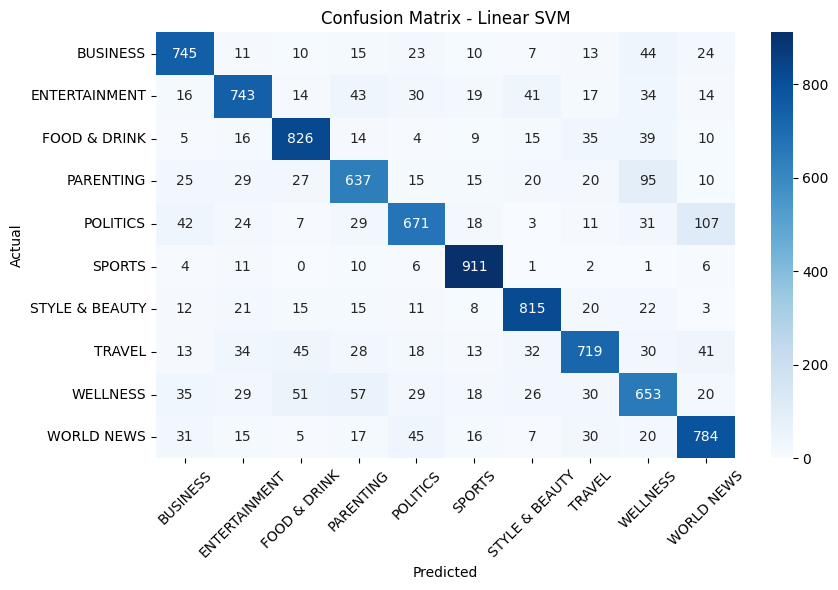

In [13]:
# Confusion Matrix
conf_mat = confusion_matrix(y_test, y_pred, labels=model.classes_)
plt.figure(figsize=(9, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=model.classes_, yticklabels=model.classes_)
plt.title("Confusion Matrix - Linear SVM")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### 9.Interactive Prediction

In [14]:
while True:
    user_input = input("\\n📝 Enter a news headline to classify:\\n> ").strip()
    if not user_input:
        print("⚠️ Please enter a non-empty headline.")
        continue

    user_input_clean = re.sub(r'[^a-z\\s]', '', user_input.lower())
    user_input_clean = re.sub(r'\\s+', ' ', user_input_clean).strip()

    user_vec = vectorizer.transform([user_input_clean])
    prediction = model.predict(user_vec)[0]

    print(f"\\n➡️ Predicted Category: {prediction}")

    cont = input("\\n🔁 Do you want to classify another headline? (yes/no):\\n> ").strip().lower()
    if cont not in ['yes', 'y']:
        print("👋 Exiting the classifier. Done!")
        break


\n➡️ Predicted Category: WELLNESS
👋 Exiting the classifier. Done!


### 10.Save Model

In [15]:
joblib.dump(model, "svm_model.pkl")
joblib.dump(vectorizer, "vectorizer.pkl")
print("✅ Model and vectorizer saved.")


✅ Model and vectorizer saved.
